# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

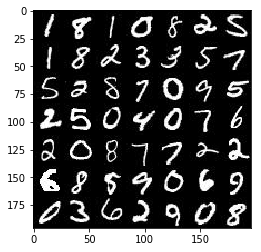

In [2]:
show_n_images = 49

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

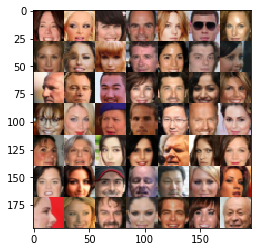

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    t_real_imgs = tf.placeholder( tf.float32, shape=[ None, image_width, image_height, image_channels ], name='real_images' )
    t_z_data    = tf.placeholder( tf.float32, shape=[ None, z_dim ], name='z_input')
    learn_rate  = tf.placeholder( tf.float32, name='learning_rate' )

    return (t_real_imgs, t_z_data, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Notes:  
    # Build a convolutional neural network
    # 1 fully connected layer at end
    # batch_norm between the layers, except for the first to second
    # no max pool layers
    # downsample is done with stride in conv layers
    # final layer is flattened connected to single sigmoid unit
    # leaky relu activations
    
    #num_units = 128
    alpha     = 0.2
    #drop_rate = 0.5
    # Leveraging code snippets from Intro_to_GANs notebook in the deep-learning repo under gan_mnist folder
    # as well as the DCGAN notebook from the dcgan-svhn folder. Also Rahul Gautam's snippets on discriminator and
    # generator confirmed my suspicion that 3 layers, rather than 2, would likely be needed for good performance.
    # Numerous forum posts indicated that dropout use was ill-advised, given only 1 training epoch used.
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input images:  28 x 28 x 3, with pixel values in range -0.5 to 0.5
        img1  = tf.layers.conv2d( images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum( alpha * img1, img1 )   # use leaky ReLU
     #   drop1 = tf.layers.dropout( relu1, drop_rate )
        # 14 x 14 x 64 out
        
        img2 = tf.layers.conv2d( relu1, 128, 4, strides=2, padding='same')
        b_norm2 = tf.layers.batch_normalization( img2, training=True )
        relu2 = tf.maximum( alpha * b_norm2, b_norm2)
      #  drop2 = tf.layers.dropout( relu2, drop_rate )
        # 7 x 7 x 128 out
        
        img3 = tf.layers.conv2d( relu2, 256, 4, strides=2, padding='same')
        b_norm3 = tf.layers.batch_normalization( img3, training=True )
        relu3 = tf.maximum( alpha * b_norm3, b_norm3)
       # drop3 = tf.layers.dropout( relu3, drop_rate )
        # 4 x 4 x 256
        
        # Flatten
        flat_layer = tf.reshape( relu3, (-1, 4*4*256))
        logits = tf.layers.dense( flat_layer, 1 )
        ouput = tf.sigmoid( logits )

    return (ouput, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Leveraging code snippets from the DCGAN notebook in the dcgan-svhn folder of deep-learning repo
    # Start out with a deep and narrow network, that eventually gets shallower and flatter until reaching
    # size of 28 x 28 x 5
    my_reuse = not is_train
    with tf.variable_scope('generator', reuse=my_reuse):
        g_alpha = 0.2
        
        x1 = tf.layers.dense( z, 2 * 2 * 512 )
                
        x1 = tf.reshape( x1, (-1, 2, 2, 512 ))
        x1 = tf.layers.batch_normalization( x1, training = is_train)
        x1 = tf.maximum( g_alpha * x1, x1 )   # leaky ReLU
        #print( "x1 size = ", x1.get_shape().as_list() )
        # output size: 4 x 4 x 512
        
        # Need valid padding to get from 4x4 to 7x7
        x2 = tf.layers.conv2d_transpose( x1, 256, kernel_size=5, strides=2, padding='valid', 
             kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x2 = tf.layers.batch_normalization( x2, training=is_train)
        x2 = tf.maximum( g_alpha * x2, x2 )   # leaky ReLU
        #print( "x2 size = ", x2.get_shape().as_list() )
        # 7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose( x2, 128, kernel_size=5, strides=2, padding='same', 
             kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x3 = tf.layers.batch_normalization( x3, training=is_train )
        x3 = tf.maximum( g_alpha * x3, x3 )
        #print( "x3 size = ", x3.get_shape().as_list() )
        # 14 x 14 x 128
        
        # output layer
        logits = tf.layers.conv2d_transpose( x3, out_channel_dim, kernel_size=5, strides=2, padding='same', 
             kernel_initializer=tf.contrib.layers.xavier_initializer() )
        #print( "logits size = ", logits.get_shape().as_list() )
        # 28 x 28 x 5
        
        #print( "out_channel_dim =", out_channel_dim )
        
        gen_out = tf.tanh( logits )
        
        return gen_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    gen_model = generator( input_z, out_channel_dim, is_train=True )
    
    # take real image input
    dsc_model_real, dsc_logits_real = discriminator(input_real, reuse=False)
    # take generator input
    dsc_model_fake, dsc_logits_fake = discriminator(gen_model, reuse=True)
    
    # Calculate loss
    dsc_loss_real = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_real, labels=tf.ones_like(dsc_model_real)))
    dsc_loss_fake = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.zeros_like(dsc_model_fake)))
    
    gen_loss      = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.ones_like(dsc_model_fake)))
    
    dsc_loss = dsc_loss_real + dsc_loss_fake
    
    return (dsc_loss, gen_loss )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dsc_vars = [ var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [ var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS)):
        dsc_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dsc_vars)
        gen_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return (dsc_train_op, gen_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    #tf.reset_default_graph()  per forum input, remove due to potential undefined behavior
    
    # Like the __init__ section of DCGAN.ipynb notebook
    # model_inputs(image_width, image_height, image_channels, z_dim)
#    print( "image_width    = ", data_shape[1] )
#    print( "image_height   = ", data_shape[2] )
#    print( "batch_size     = ", batch_size )
#    print( "z_dim          = ", z_dim )
    
    # model_inputs(image_width, image_height, image_channels, z_dim)
    real_imgs, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # model_loss(input_real, input_z, out_channel_dim)
    dsc_loss, gen_loss = model_loss(real_imgs, z_data, data_shape[3])
    
    # model_opt(d_loss, g_loss, learning_rate, beta1)
    dsc_train_op, gen_train_op = model_opt(dsc_loss, gen_loss, learning_rate, beta1)

    samples, losses = [], []
    
    print_cycle = 10
    show_cycle  = 100
    steps       = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images since they are normalized to -0.5 to 0.5, and tanh outputs -1.0 to 1.0
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform( -1.0, 1.0, size=(batch_size, z_dim ) )
                #batch_z = np.random.uniform( -0.5, 0.5, size=(batch_size, z_dim ) )
                
                # Run optimizers
                _ = sess.run( dsc_train_op, feed_dict={ real_imgs: batch_images, 
                                                        z_data: batch_z })
                
                # Run generator twice to give it a better chance, per forum feedback
                _ = sess.run( gen_train_op, feed_dict={ z_data: batch_z,
                                                        real_imgs: batch_images } )

                _ = sess.run( gen_train_op, feed_dict={ z_data: batch_z,
                                                        real_imgs: batch_images } )

                
                if steps % print_cycle == 0:
                    train_loss_dsc = dsc_loss.eval({ z_data: batch_z, real_imgs: batch_images }) 
                    train_loss_gen = gen_loss.eval({ z_data: batch_z })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dsc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                    
                    # Save losses to view after training
                    losses.append((train_loss_dsc, train_loss_gen))                    
                
                if steps % show_cycle == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
        
        #saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.8227... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 3.3774... Generator Loss: 0.1527
Epoch 1/2... Discriminator Loss: 1.5245... Generator Loss: 0.4950
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 2.0594
Epoch 1/2... Discriminator Loss: 1.8611... Generator Loss: 2.3127
Epoch 1/2... Discriminator Loss: 1.8894... Generator Loss: 0.2991
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.9610... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 1.1895
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.9640


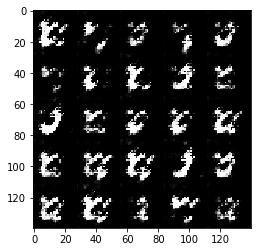

Epoch 1/2... Discriminator Loss: 1.5080... Generator Loss: 1.8076
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.4455
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 3.0614
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.4522
Epoch 1/2... Discriminator Loss: 1.7094... Generator Loss: 2.9027
Epoch 1/2... Discriminator Loss: 2.4518... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.6353... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.6413


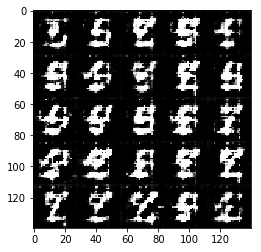

Epoch 1/2... Discriminator Loss: 1.6683... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 1.1998
Epoch 1/2... Discriminator Loss: 1.9260... Generator Loss: 0.2384
Epoch 1/2... Discriminator Loss: 1.4471... Generator Loss: 1.7021
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 1.9169
Epoch 1/2... Discriminator Loss: 1.6033... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.7385... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 1.0157


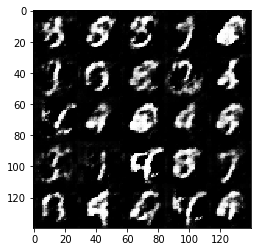

Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.7220... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.7990... Generator Loss: 0.3227
Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 1.5297... Generator Loss: 0.5106


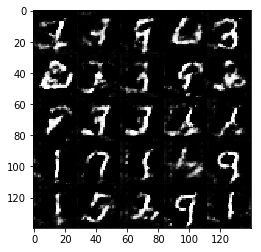

Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 0.4157
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.3845
Epoch 1/2... Discriminator Loss: 1.6816... Generator Loss: 0.3697
Epoch 1/2... Discriminator Loss: 2.0679... Generator Loss: 0.1703
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.1144
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.4540


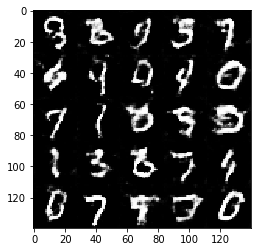

Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.6596... Generator Loss: 0.3845
Epoch 1/2... Discriminator Loss: 1.6594... Generator Loss: 0.4836
Epoch 1/2... Discriminator Loss: 1.6990... Generator Loss: 0.2747
Epoch 1/2... Discriminator Loss: 2.0583... Generator Loss: 0.2110
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 1.6176... Generator Loss: 0.3230
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.6054
Epoch 1/2... Discriminator Loss: 1.6005... Generator Loss: 0.9617
Epoch 1/2... Discriminator Loss: 1.5950... Generator Loss: 0.6862


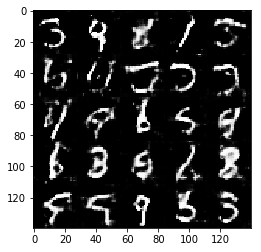

Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.4119
Epoch 1/2... Discriminator Loss: 1.6341... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.4619
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.4472
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 1.3363
Epoch 1/2... Discriminator Loss: 2.1943... Generator Loss: 1.5488
Epoch 1/2... Discriminator Loss: 1.8696... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 1.7585... Generator Loss: 0.4171
Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 1.5324... Generator Loss: 0.8217


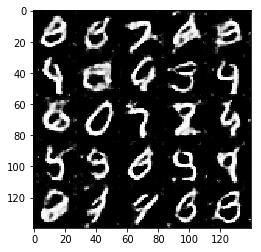

Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.4862
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.5171... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 1.6995... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.4613
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.7500


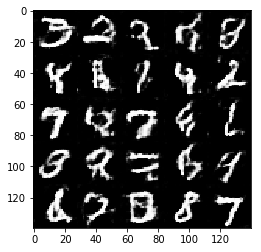

Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.4918
Epoch 1/2... Discriminator Loss: 1.5859... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.6337... Generator Loss: 0.3547
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 0.7465


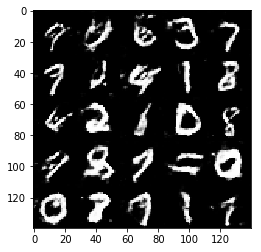

Epoch 1/2... Discriminator Loss: 2.4178... Generator Loss: 1.9672
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.7110... Generator Loss: 0.2840
Epoch 1/2... Discriminator Loss: 1.7974... Generator Loss: 0.2613
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 2.0356... Generator Loss: 0.1978
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 1.8572... Generator Loss: 0.2119


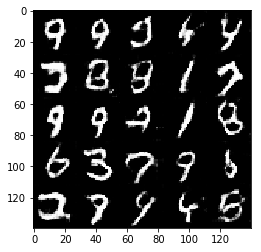

Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 1.7561... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 2.2562... Generator Loss: 0.1813


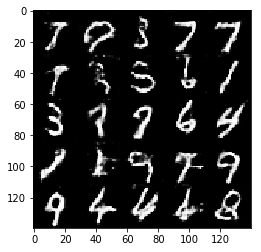

Epoch 1/2... Discriminator Loss: 1.5812... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 2.2287... Generator Loss: 0.1437
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.7255... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 1.7296... Generator Loss: 0.2610
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 1.8804... Generator Loss: 0.2088
Epoch 1/2... Discriminator Loss: 1.6426... Generator Loss: 1.0011
Epoch 1/2... Discriminator Loss: 1.5461... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.7299... Generator Loss: 0.3197


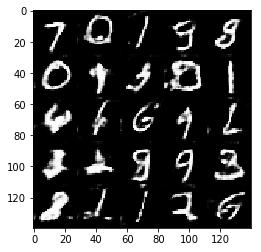

Epoch 1/2... Discriminator Loss: 1.6527... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.2913
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.5785
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.4065
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 1.9063... Generator Loss: 0.2091
Epoch 1/2... Discriminator Loss: 2.0701... Generator Loss: 0.1720
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.4599
Epoch 1/2... Discriminator Loss: 2.1719... Generator Loss: 0.1758


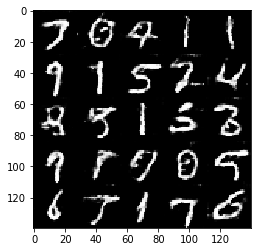

Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 1.4403
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 0.3186
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.5820
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 1.7578... Generator Loss: 0.2964
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.8667


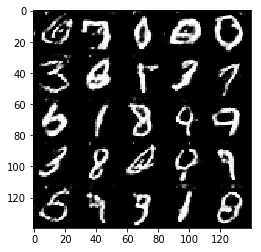

Epoch 1/2... Discriminator Loss: 1.6907... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 1.5356... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.4356
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 2.1355... Generator Loss: 0.1852
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.9049... Generator Loss: 0.2402
Epoch 1/2... Discriminator Loss: 1.7642... Generator Loss: 0.2418
Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.3944


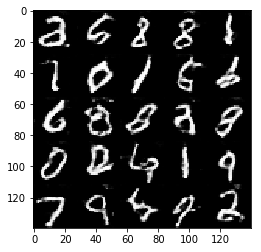

Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.5225
Epoch 1/2... Discriminator Loss: 2.1995... Generator Loss: 0.1795
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.4099
Epoch 1/2... Discriminator Loss: 2.3963... Generator Loss: 0.1465
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.8118... Generator Loss: 0.2362
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 1.6936... Generator Loss: 0.3058
Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.8264... Generator Loss: 0.2777


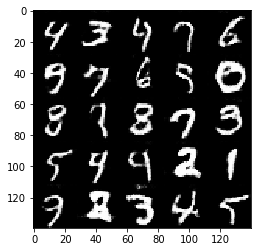

Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.3810
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 0.3625
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.1457
Epoch 1/2... Discriminator Loss: 1.5826... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.6084... Generator Loss: 0.3930
Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 0.3976
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.4199
Epoch 1/2... Discriminator Loss: 1.8123... Generator Loss: 0.2484
Epoch 1/2... Discriminator Loss: 1.9957... Generator Loss: 0.2380
Epoch 1/2... Discriminator Loss: 2.4327... Generator Loss: 0.1462


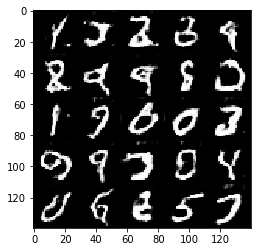

Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 0.9500
Epoch 1/2... Discriminator Loss: 1.5381... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.9889... Generator Loss: 0.1992
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.4905


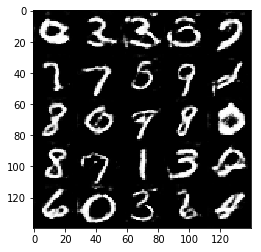

Epoch 1/2... Discriminator Loss: 2.8639... Generator Loss: 0.0850
Epoch 1/2... Discriminator Loss: 2.3337... Generator Loss: 0.1637
Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.3516
Epoch 1/2... Discriminator Loss: 2.3151... Generator Loss: 0.1441
Epoch 1/2... Discriminator Loss: 1.6813... Generator Loss: 0.3318
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 1.6936... Generator Loss: 0.2819
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.6154
Epoch 2/2... Discriminator Loss: 2.2841... Generator Loss: 0.1407
Epoch 2/2... Discriminator Loss: 2.0152... Generator Loss: 0.1938


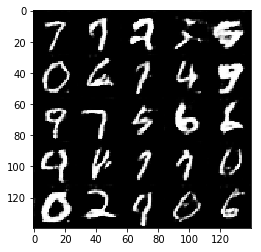

Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.4445
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 2.2317... Generator Loss: 0.1684
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.4009
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.6977... Generator Loss: 0.2831
Epoch 2/2... Discriminator Loss: 1.8534... Generator Loss: 0.2584
Epoch 2/2... Discriminator Loss: 1.5189... Generator Loss: 0.5543


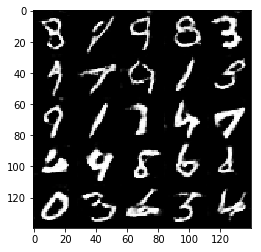

Epoch 2/2... Discriminator Loss: 1.5238... Generator Loss: 0.9072
Epoch 2/2... Discriminator Loss: 1.6428... Generator Loss: 0.3247
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 2.5667... Generator Loss: 0.1355
Epoch 2/2... Discriminator Loss: 2.3916... Generator Loss: 2.7440
Epoch 2/2... Discriminator Loss: 2.0335... Generator Loss: 0.2238
Epoch 2/2... Discriminator Loss: 2.0960... Generator Loss: 0.2275
Epoch 2/2... Discriminator Loss: 1.7285... Generator Loss: 0.2983
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.3918
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 1.5132


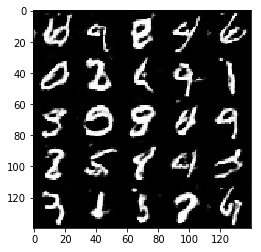

Epoch 2/2... Discriminator Loss: 1.9586... Generator Loss: 0.1822
Epoch 2/2... Discriminator Loss: 1.8888... Generator Loss: 0.2677
Epoch 2/2... Discriminator Loss: 1.5971... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.4599
Epoch 2/2... Discriminator Loss: 1.5517... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 2.0045... Generator Loss: 0.1958
Epoch 2/2... Discriminator Loss: 1.8182... Generator Loss: 0.2494
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.4045
Epoch 2/2... Discriminator Loss: 2.0343... Generator Loss: 0.2089
Epoch 2/2... Discriminator Loss: 2.3925... Generator Loss: 0.1552


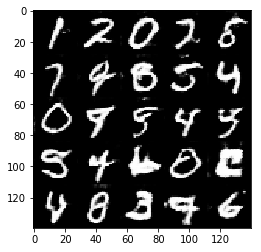

Epoch 2/2... Discriminator Loss: 2.1227... Generator Loss: 0.2062
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.3974
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 1.0942
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.7334... Generator Loss: 0.2938
Epoch 2/2... Discriminator Loss: 1.6467... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 1.9082... Generator Loss: 0.2233
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 2.0118
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 2.5111... Generator Loss: 0.1400


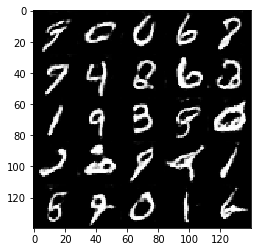

Epoch 2/2... Discriminator Loss: 1.9441... Generator Loss: 0.2629
Epoch 2/2... Discriminator Loss: 1.9668... Generator Loss: 0.2421
Epoch 2/2... Discriminator Loss: 1.9595... Generator Loss: 0.2402
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 2.7397... Generator Loss: 0.1274
Epoch 2/2... Discriminator Loss: 1.7667... Generator Loss: 0.2758
Epoch 2/2... Discriminator Loss: 1.6013... Generator Loss: 0.4563
Epoch 2/2... Discriminator Loss: 1.7543... Generator Loss: 0.2587
Epoch 2/2... Discriminator Loss: 1.6947... Generator Loss: 0.3029
Epoch 2/2... Discriminator Loss: 2.9707... Generator Loss: 0.0889


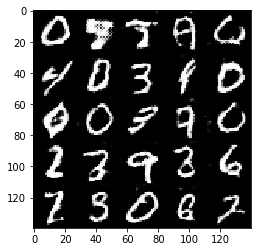

Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 2.7546... Generator Loss: 0.1119
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.9193... Generator Loss: 0.2838
Epoch 2/2... Discriminator Loss: 1.9185... Generator Loss: 0.2505
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 1.6798... Generator Loss: 0.3529


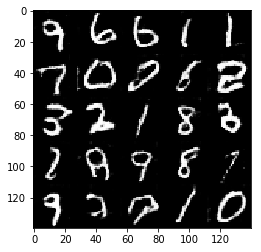

Epoch 2/2... Discriminator Loss: 2.2390... Generator Loss: 0.1712
Epoch 2/2... Discriminator Loss: 2.0553... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.6874... Generator Loss: 0.2550
Epoch 2/2... Discriminator Loss: 1.4745... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 1.9231... Generator Loss: 0.2561
Epoch 2/2... Discriminator Loss: 1.8673... Generator Loss: 0.2739
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.6637
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 1.8284... Generator Loss: 0.2464


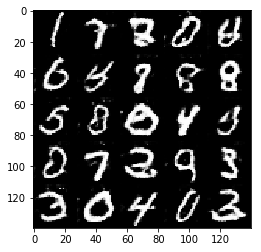

Epoch 2/2... Discriminator Loss: 1.8704... Generator Loss: 0.2851
Epoch 2/2... Discriminator Loss: 2.1744... Generator Loss: 0.2296
Epoch 2/2... Discriminator Loss: 2.0482... Generator Loss: 0.2009
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 1.7929... Generator Loss: 0.3331
Epoch 2/2... Discriminator Loss: 1.5570... Generator Loss: 0.4694
Epoch 2/2... Discriminator Loss: 1.5479... Generator Loss: 0.3676
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.4877
Epoch 2/2... Discriminator Loss: 2.3587... Generator Loss: 0.1606
Epoch 2/2... Discriminator Loss: 1.9527... Generator Loss: 0.2379


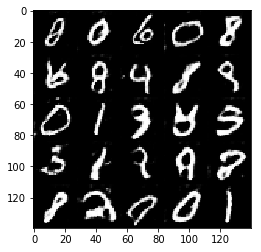

Epoch 2/2... Discriminator Loss: 2.4472... Generator Loss: 0.1332
Epoch 2/2... Discriminator Loss: 2.6225... Generator Loss: 0.1669
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 1.4565
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 1.7370... Generator Loss: 0.3058
Epoch 2/2... Discriminator Loss: 1.8760... Generator Loss: 0.2383
Epoch 2/2... Discriminator Loss: 1.5014... Generator Loss: 0.4055
Epoch 2/2... Discriminator Loss: 3.1431... Generator Loss: 0.0753
Epoch 2/2... Discriminator Loss: 1.8290... Generator Loss: 0.3105


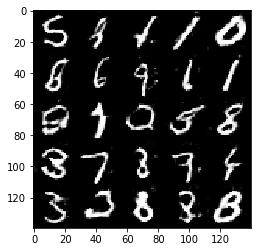

Epoch 2/2... Discriminator Loss: 2.1750... Generator Loss: 0.2497
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.5946
Epoch 2/2... Discriminator Loss: 2.1730... Generator Loss: 0.2178
Epoch 2/2... Discriminator Loss: 2.7451... Generator Loss: 0.1488
Epoch 2/2... Discriminator Loss: 2.2745... Generator Loss: 0.1827
Epoch 2/2... Discriminator Loss: 1.5390... Generator Loss: 0.3908
Epoch 2/2... Discriminator Loss: 1.9613... Generator Loss: 0.2847
Epoch 2/2... Discriminator Loss: 1.5391... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 1.8473... Generator Loss: 0.3267
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.1534


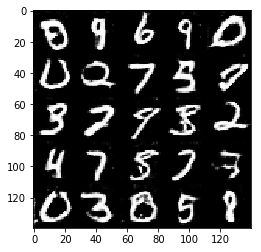

Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 2.1646... Generator Loss: 0.2173
Epoch 2/2... Discriminator Loss: 1.9996... Generator Loss: 0.2343
Epoch 2/2... Discriminator Loss: 2.1989... Generator Loss: 0.2383
Epoch 2/2... Discriminator Loss: 1.7938... Generator Loss: 0.4069
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 2.5270... Generator Loss: 0.1355
Epoch 2/2... Discriminator Loss: 2.1177... Generator Loss: 0.2287


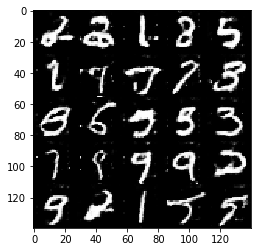

Epoch 2/2... Discriminator Loss: 2.6178... Generator Loss: 0.1259
Epoch 2/2... Discriminator Loss: 2.5719... Generator Loss: 0.1352
Epoch 2/2... Discriminator Loss: 2.2266... Generator Loss: 0.2365
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.6696
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 1.8853... Generator Loss: 0.5650
Epoch 2/2... Discriminator Loss: 2.1025... Generator Loss: 0.1930
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 2.6577... Generator Loss: 0.1392
Epoch 2/2... Discriminator Loss: 1.9419... Generator Loss: 0.2796


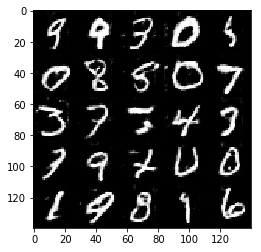

Epoch 2/2... Discriminator Loss: 2.2350... Generator Loss: 0.1968
Epoch 2/2... Discriminator Loss: 2.7047... Generator Loss: 0.0954
Epoch 2/2... Discriminator Loss: 1.7783... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 2.6881... Generator Loss: 0.1038
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 2.0308... Generator Loss: 0.2487
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.5531
Epoch 2/2... Discriminator Loss: 2.1069... Generator Loss: 0.1699
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.4251


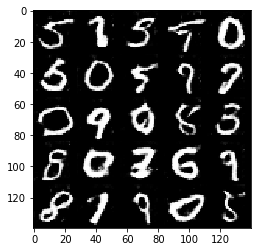

Epoch 2/2... Discriminator Loss: 2.4339... Generator Loss: 0.1815
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 2.3811
Epoch 2/2... Discriminator Loss: 2.8797... Generator Loss: 0.1292
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 2.4875... Generator Loss: 0.1439
Epoch 2/2... Discriminator Loss: 2.7117... Generator Loss: 0.1051
Epoch 2/2... Discriminator Loss: 2.1177... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 2.3338... Generator Loss: 0.1713
Epoch 2/2... Discriminator Loss: 2.1176... Generator Loss: 0.2257


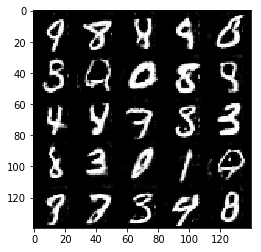

Epoch 2/2... Discriminator Loss: 1.9822... Generator Loss: 0.2620
Epoch 2/2... Discriminator Loss: 2.2327... Generator Loss: 0.1508
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.8410... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 1.5975... Generator Loss: 3.6183
Epoch 2/2... Discriminator Loss: 2.0199... Generator Loss: 0.2188
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 1.8944... Generator Loss: 0.2679
Epoch 2/2... Discriminator Loss: 2.0059... Generator Loss: 0.2430
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 1.1019


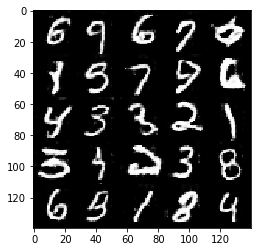

Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 2.5989... Generator Loss: 0.2759
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 2.7161... Generator Loss: 0.1839
Epoch 2/2... Discriminator Loss: 2.4160... Generator Loss: 0.1549
Epoch 2/2... Discriminator Loss: 1.9456... Generator Loss: 0.2409
Epoch 2/2... Discriminator Loss: 1.7932... Generator Loss: 0.2745
Epoch 2/2... Discriminator Loss: 2.3703... Generator Loss: 0.1752
Epoch 2/2... Discriminator Loss: 2.5703... Generator Loss: 0.1287


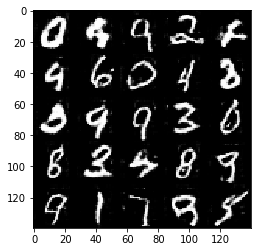

Epoch 2/2... Discriminator Loss: 1.9907... Generator Loss: 0.3299
Epoch 2/2... Discriminator Loss: 2.3792... Generator Loss: 0.1632
Epoch 2/2... Discriminator Loss: 2.8103... Generator Loss: 0.1223
Epoch 2/2... Discriminator Loss: 2.2247... Generator Loss: 0.1636
Epoch 2/2... Discriminator Loss: 2.9935... Generator Loss: 0.1347
Epoch 2/2... Discriminator Loss: 2.1123... Generator Loss: 0.2238
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 1.8478... Generator Loss: 0.2278
Epoch 2/2... Discriminator Loss: 1.5171... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 0.7277


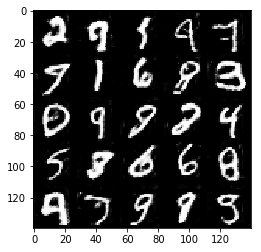

Epoch 2/2... Discriminator Loss: 1.6727... Generator Loss: 0.3659
Epoch 2/2... Discriminator Loss: 2.8357... Generator Loss: 0.1048
Epoch 2/2... Discriminator Loss: 2.0649... Generator Loss: 0.2378
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.3983
Epoch 2/2... Discriminator Loss: 2.0453... Generator Loss: 0.2444
Epoch 2/2... Discriminator Loss: 2.2794... Generator Loss: 0.1838
Epoch 2/2... Discriminator Loss: 2.3491... Generator Loss: 0.1876
Epoch 2/2... Discriminator Loss: 2.0662... Generator Loss: 0.2278
Epoch 2/2... Discriminator Loss: 2.2022... Generator Loss: 0.2077
Epoch 2/2... Discriminator Loss: 2.5422... Generator Loss: 0.1501


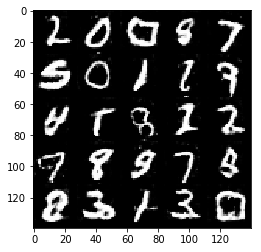

Epoch 2/2... Discriminator Loss: 2.7835... Generator Loss: 0.1046
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.1262
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.3871
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.7421


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.9012... Generator Loss: 0.0075
Epoch 1/1... Discriminator Loss: 4.0417... Generator Loss: 0.0628
Epoch 1/1... Discriminator Loss: 4.3177... Generator Loss: 0.1292
Epoch 1/1... Discriminator Loss: 2.6367... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 2.1488... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 2.0283... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.8381... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9796


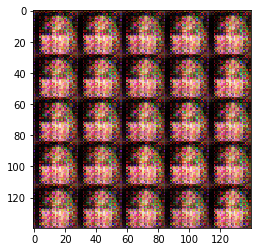

Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 1.9307... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 1.5901


Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.5414
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 1.6708
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.3217... Generator Loss: 1.8415
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.9683
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.9260


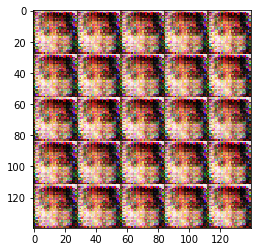

Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.4275
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 1.6898
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 1.9531
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 2.0485
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.3352
Epoch 1/1... Discriminator Loss: 2.1196... Generator Loss: 0.4840


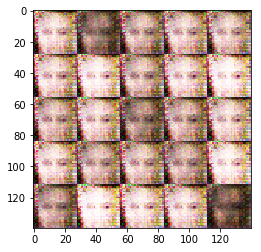

Epoch 1/1... Discriminator Loss: 1.6412... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.9184... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.9149... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.9512... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 2.2678... Generator Loss: 0.3948
Epoch 1/1... Discriminator Loss: 2.0947... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.6576


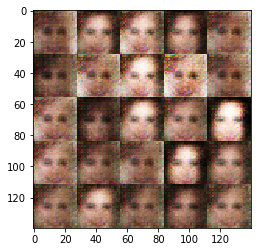

Epoch 1/1... Discriminator Loss: 1.7314... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.5872


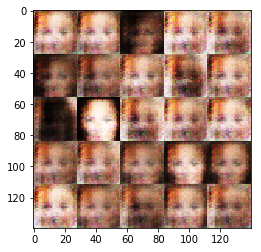

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.7985... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.6513


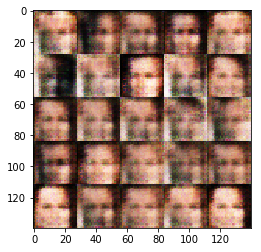

Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7493


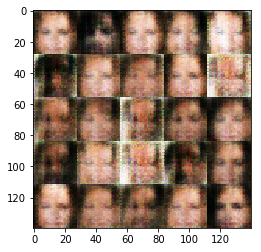

Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.5977


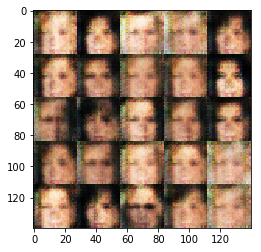

Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.6339


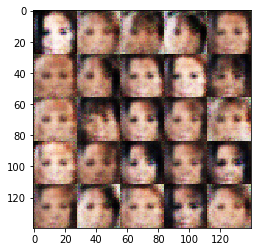

Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.7519... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6156


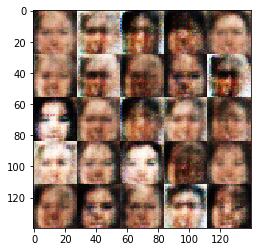

Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6073


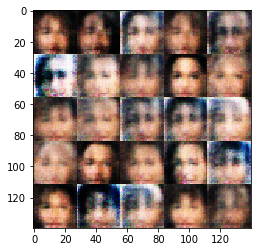

Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6568


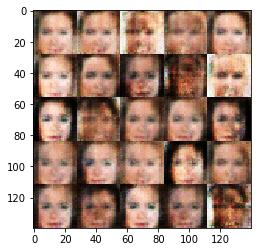

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.5981


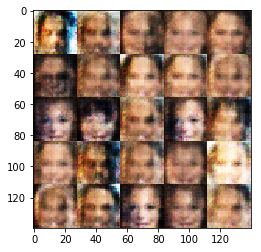

Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6508


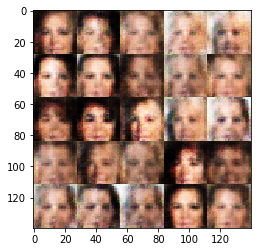

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6829


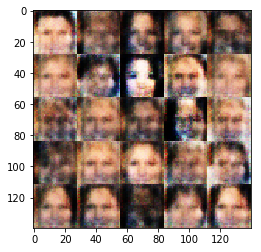

Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6921


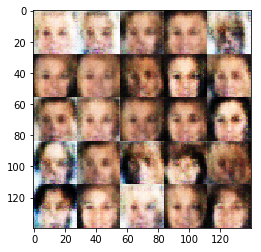

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6361


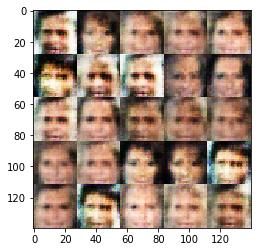

Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.6229


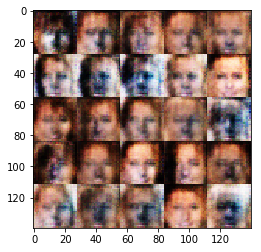

Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6219


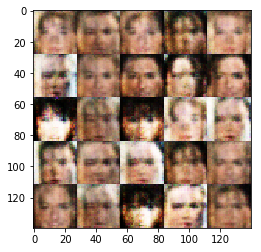

Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6416


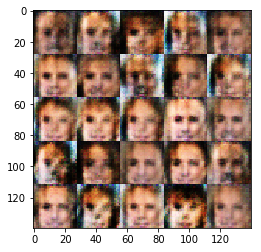

Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7162


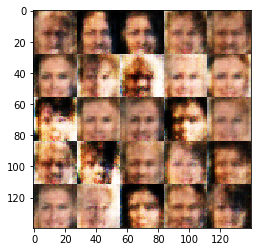

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6806


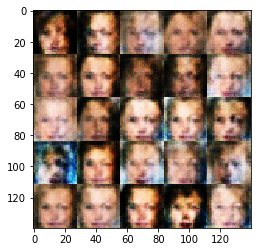

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6038


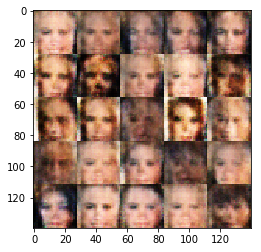

Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6596


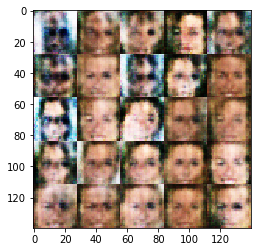

Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.6122


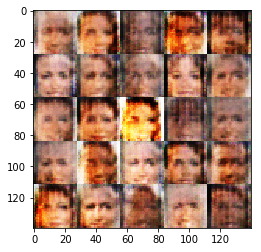

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6581


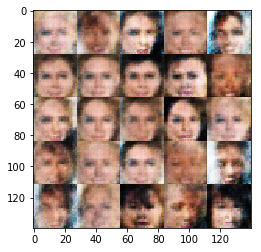

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6410


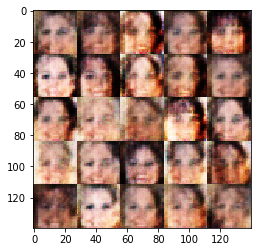

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.7138


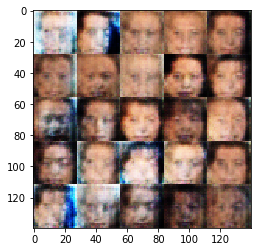

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.5976


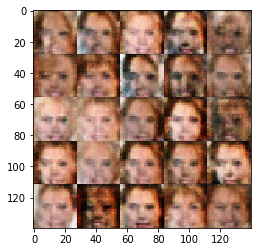

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6584


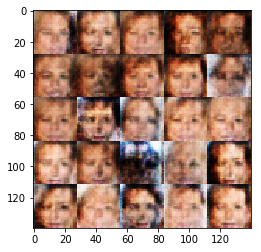

Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6139


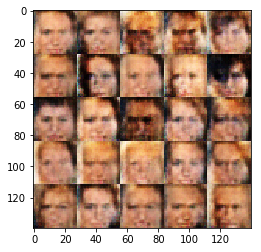

Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7184


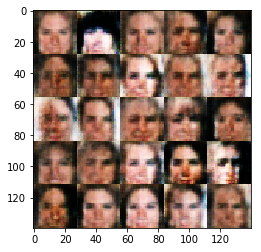

Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7127


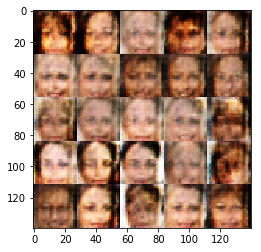

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6659


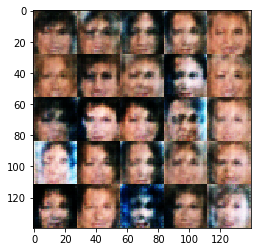

Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6679


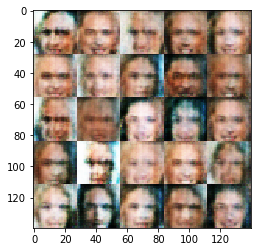

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6731


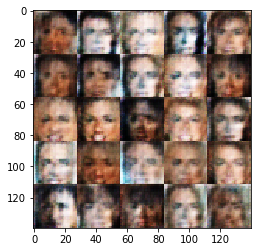

Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6261


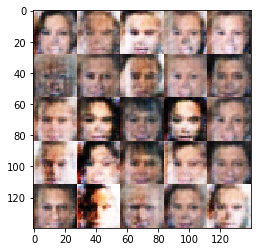

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5885


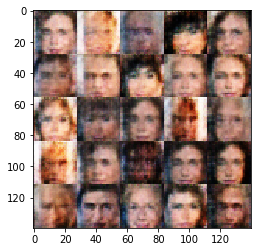

Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6533


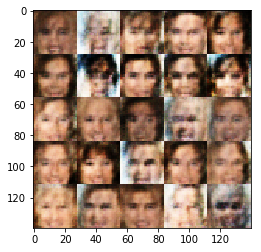

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6550


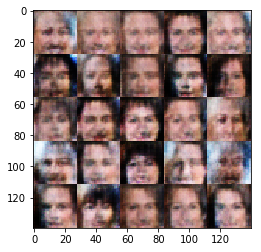

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6706


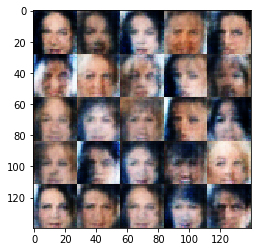

Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6657


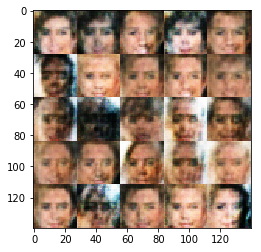

Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.6400


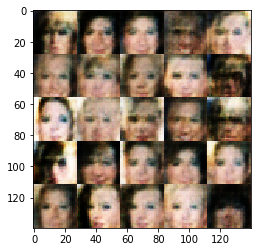

Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6734


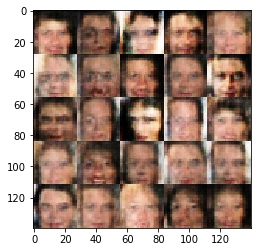

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7452


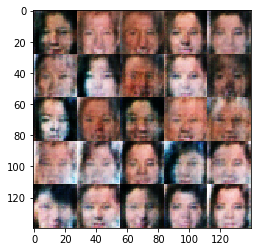

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6309


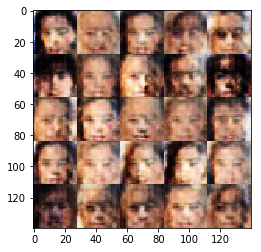

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6707


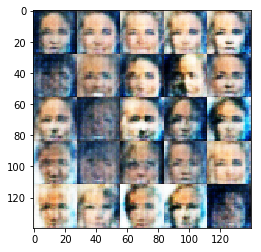

Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6647


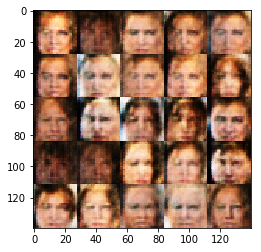

Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6810


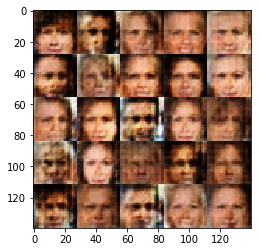

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6634


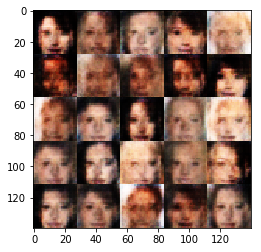

Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6671


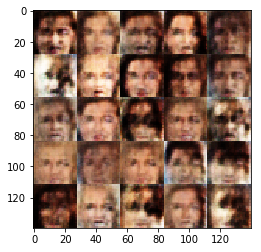

Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6869


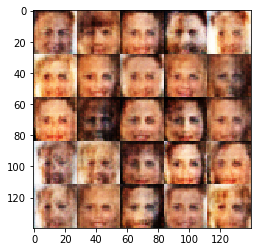

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6690


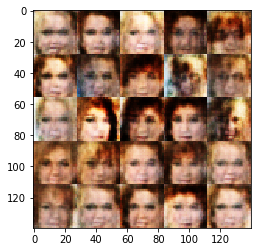

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6985


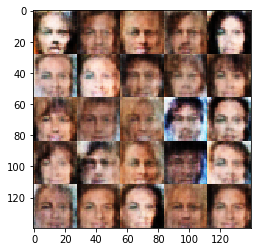

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6428


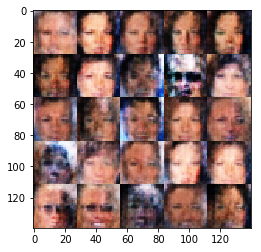

Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6678


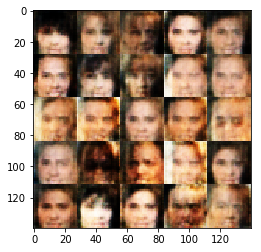

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6570


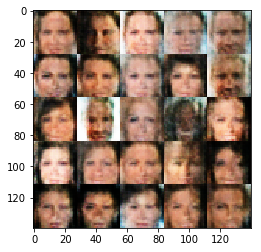

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6812


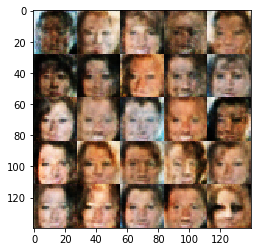

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7016


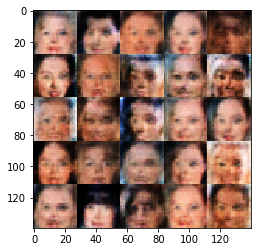

Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6770


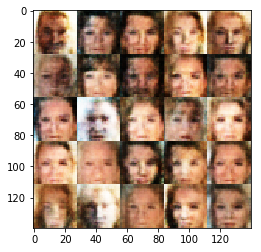

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6852


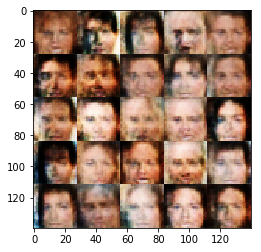

Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6379


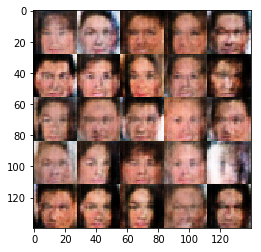

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6891


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.